In [7]:
import pandas as pd
import rasterio
import numpy as np

In [8]:
crta_coords = pd.read_csv('calculate_aoo/df2csv/cornuta_all.csv')

In [9]:
crta_coords

,lat,long
0,51.024975,13.708278
1,51.024975,13.708278
2,51.024975,13.791615
3,51.024975,13.791615
4,51.024975,13.791615
...,...,...
32411,49.517217,8.201899
32412,49.463610,8.290625
32413,49.463143,8.290715
32414,49.463592,8.290598


In [10]:
crta_coords = crta_coords[(crta_coords['lat']>0) & (crta_coords['long']>-20)]

In [23]:
crta_coords[crta_coords['lat'] ==crta_coords['lat'].min()]

,lat,long
282,34.9625,33.02917


In [12]:
with rasterio.open('/home/mpgetz/file_share/train/repos/bee_mapping/data/wc2.1_30s_bio/wc2.1_30s_bio_1.tif') as dataset:
    # Pixel width and height (resolution) in geographic units
    lat_resolution, long_resolution = dataset.res[0], dataset.res[1]
    transform = dataset.transform
    pixel_size_x, pixel_size_y = dataset.res
    raster_crs = dataset.crs

In [13]:
import geopandas as gpd
from shapely.geometry import Point

# Convert your DataFrame 'df' to a GeoDataFrame
gdf = gpd.GeoDataFrame(crta_coords, geometry=[Point(xy) for xy in zip(crta_coords.long, crta_coords.lat)])

# Set the CRS for the GeoDataFrame to WGS 84 (used for latitude and longitude)
gdf.set_crs(epsg=4326, inplace=True)

gdf = gdf.to_crs(raster_crs)


In [14]:
def align_to_raster(row, transform):
    x, y = row.geometry.x, row.geometry.y

    # Inverse transform to get row and col in raster space
    row, col = ~transform * (x, y)
    row, col = np.round(row), np.round(col)  # Round to nearest pixel

    # Transform back to raster CRS
    x_aligned, y_aligned = transform * (col, row)
    return Point(x_aligned, y_aligned)

gdf['aligned_geometry'] = gdf.apply(align_to_raster, transform=transform, axis=1)


In [15]:
gdf_unique = gdf.drop_duplicates(subset=['aligned_geometry'])

In [16]:
crta_coords_filtered = gdf_unique[['lat', 'long']]


In [17]:
print(f'before: {len(crta_coords)}, after: {len(crta_coords_filtered)}')

before: 32413, after: 6494


In [18]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')

shapefile_path = 'data/shapefiles/ne_110m_land/ne_110m_land.shp'
gdf = gpd.read_file(shapefile_path)

lakes_shapefile_path = 'data/shapefiles/ne_110m_lakes/ne_110m_lakes.shp'
lakes_gdf = gpd.read_file(lakes_shapefile_path)

cities = {
    "Paris": (48.8566, 2.3522),
    "Berlin": (52.5200, 13.4050),
    "Madrid": (40.4168, -3.7038),
    "Rome": (41.9028, 12.4964),
    "London": (51.5074, -0.1278),  
    "Amsterdam": (52.3676, 4.9041),
    "Vienna": (48.2082, 16.3738),
    "Lisbon": (38.7223, -9.1393),
    "Brussels": (50.8503, 4.3517),
    "Warsaw": (52.2297, 21.0122),
    "Budapest": (47.4979, 19.0402),
    "Prague": (50.0755, 14.4378),
    "Stockholm": (59.3293, 18.0686),
    "Copenhagen": (55.6761, 12.5683),
    "Athens": (37.9838, 23.7275),
    "Oslo": (59.9139, 10.7522),
    "Helsinki": (60.1699, 24.9384),
    "Zurich": (47.3769, 8.5417),
    "Barcelona": (41.3851, 2.1734),
    "Munich": (48.1351, 11.5820)
}


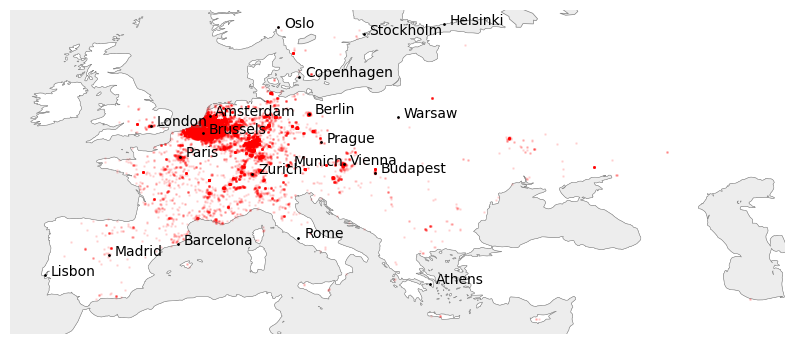

In [19]:
plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax = plt.gca()

ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

ax.scatter(crta_coords['long'], crta_coords['lat'], transform=ccrs.PlateCarree(), marker='o', color='red', s=1, alpha=.1)
ax.axis('off')

for city, (lat, lon) in cities.items():
    ax.plot(lon, lat, 'o', markersize=1, color='k', transform=ccrs.Geodetic())
    ax.text(lon + .5, lat + 0, city, transform=ccrs.Geodetic())

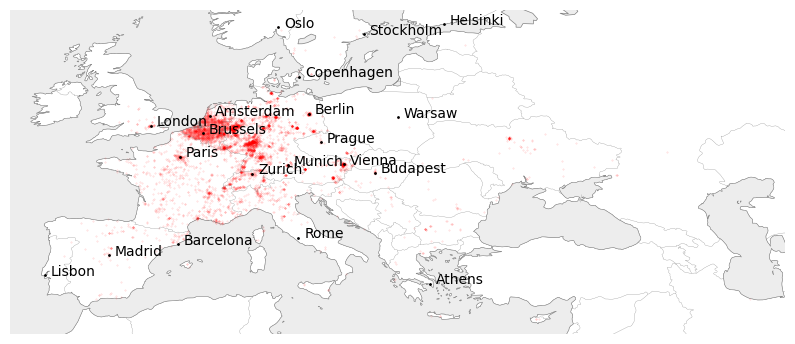

In [22]:
plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax = plt.gca()

ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

ax.scatter(crta_coords_filtered['long'], crta_coords_filtered['lat'], transform=ccrs.PlateCarree(), marker='o', color='red', s=.1, alpha=.2)
ax.axis('off')

for city, (lat, lon) in cities.items():
    ax.plot(lon, lat, 'o', markersize=1, color='k', transform=ccrs.Geodetic())
    ax.text(lon + .5, lat + 0, city, transform=ccrs.Geodetic())

plt.savefig('dist.png', format='png', dpi=300)

In [21]:
crta_coords_filtered.to_csv('crta_coords_filtered.csv', index=False)